<h1><center>ROOFIT</center></h1>
<h2><center>ROOT's Library for Modelling and Fitting </center></h2>

RooFit is essentially a library of toolkits for modelling. Some analysis requires the event distribution to be modelled, performing unbinned maximum likelihood fits or even to generate toy Monte Carlo samples. 

RooFit works a bit different from the standard ROOT TF1 fits. Let's go through it one by one.



In [1]:
import ROOT

Welcome to JupyROOT 6.22/00


# Basic Functionalities

## Build a Model

First off, let's see how you would build a model. You need models in order to generate MC or to fit to a dataset.

RooFit's main concept is that models are object-oriented, where each class corresponds to a mathematical object. For example:

* Variables are expressed by **RooRealVar**
* Functions are expressed by **RooAbsReal**
* Probability Distribution Functions (PDFs) are expressed by **RooAbsPdf**

and so on. The simplest mathematical function utilizes RooFit objects.

Let's build a model for a Gaussian distribution using the **RooGaussian** class.


In [8]:
# declare the variable x with range(-10, 10)
x = ROOT.RooRealVar("x", "x", -10, 10)

# declare the mean of the gaussian with initial value x, and floating range(-5, 5)
m = ROOT.RooRealVar("m", "gaussian mean", 3, -5, 5)

# declare the gaussian width
s = ROOT.RooRealVar("s", "gaussian width", 1, 0, 2)

# build the gaussian pdf model
gaus = ROOT.RooGaussian("gaus", "gaussian PDF", x, m, s)

As you see above, each RooRealVar objects follows the standard ROOT object declaration with its own unique name, a title (not necessarily unique), the range, and an sometimes an initial value (such as in `m` and `s`).

The **RooRealVar** class collects all the basic information of the variables.

With the variables, we then create a Gaussian pdf with **RooGaussian**, that inherits from **RooAbsPdf** that carries the basic attributes of a probaility distribution function.

## RooPlot: Plotting and Visualization

To plot the models are datasets, we will need to use the **RooPlot** class. First, we need to build a 'frame' for the objects to be placed in.

In [9]:
frame = x.frame(ROOT.RooFit.Title("Gaussian PDF"))

Now, with the frame, plot the objects in. The plotting attributes can be accessed in a familiar way to the main ROOT plotting method, as below:

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


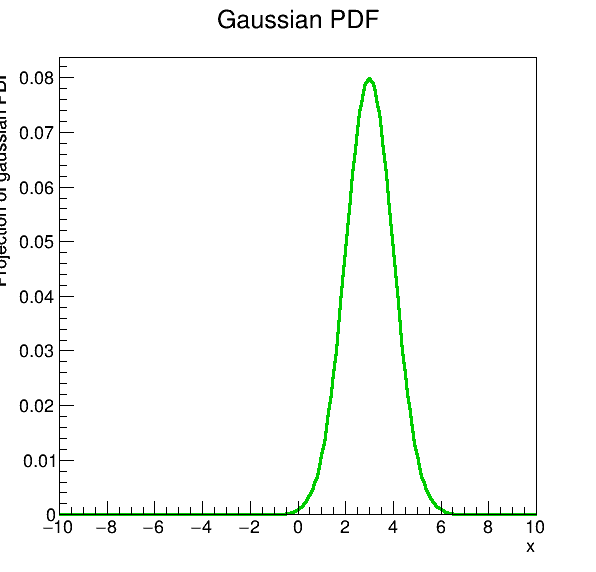

In [10]:
gaus.plotOn(frame, ROOT.RooFit.LineColor(ROOT.kGreen+1))

c = ROOT.TCanvas("c", "canvas", 600, 600)
frame.Draw()
c.Draw()

## Generate Monte Carlo Events

From the **RooAbsPdf** class, we can generate a dataset of MC events with the **RooDataSet** class.

We will generate 1000 events along the `x` variable:

RooDataSet::gausData[x] = 1000 entries


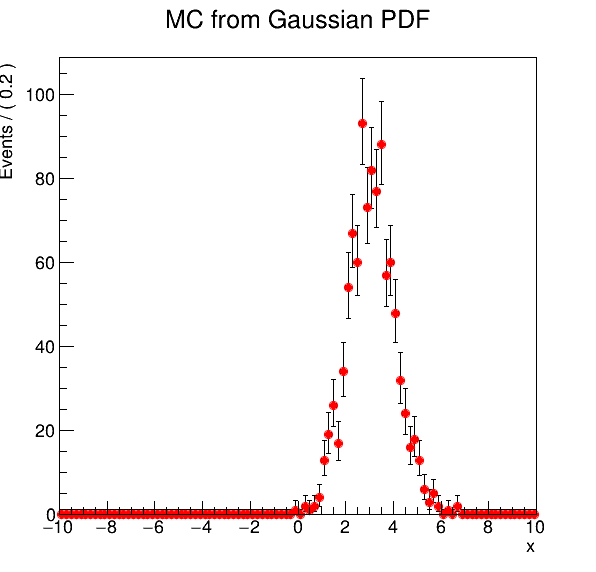

In [20]:
data = gaus.generate(x, 1000)
data.Print()

frame2 = x.frame(ROOT.RooFit.Title("MC from Gaussian PDF"))

c.Clear()
data.plotOn(frame2, ROOT.RooFit.MarkerColor(ROOT.kRed))
frame2.Draw()
c.Draw()

## Fitting

The dataset above can then be fitted with the pdf. The result can be saved by placing the activating the flag `Save()` in the fitting options, which will return a **RooFitResult**.

In [27]:
fitResult = gaus.fitTo(data, ROOT.RooFit.Save())

# obtain the correlation matrix from the RooFitResult
corMatrix = fitResult.correlationMatrix()
corMatrix.Print()

[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
 **********
 **   28 **SET PRINT           1
 **********
 **********
 **   29 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 m            3.09963e+00  3.08837e-02   -5.00000e+00  5.00000e+00
     2 s            9.76638e-01  2.18365e-02    0.00000e+00  2.00000e+00
 **********
 **   30 **SET ERR         0.5
 **********
 **********
 **   31 **SET PRINT           1
 **********
 **********
 **   32 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **   33 **MIGRAD        1000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
 FCN=1395.3 FROM MIGRAD    STATUS=INITIATE        4 CALLS           5 TOTAL
                     EDM= unknown      STRATEGY= 1      NO ERROR MATRIX  

[#1] INFO:Plotting -- RooAbsPdf::plotOn(gaus) only plotting range [-2,8], curve is normalized to data in given range


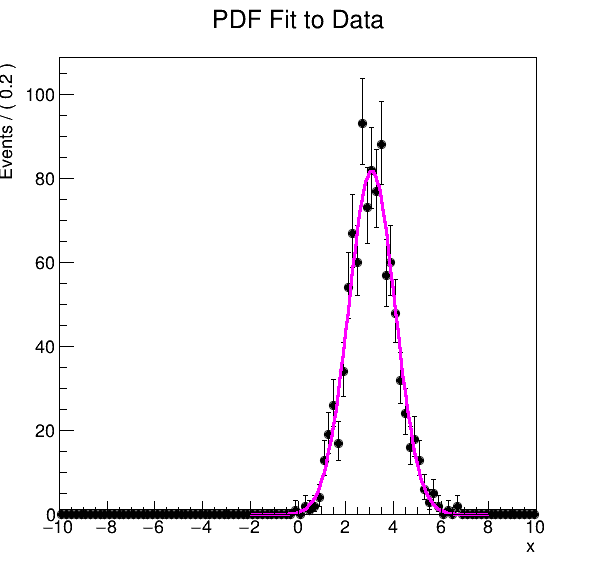

In [40]:
# declare a frame
frame3 = x.frame(ROOT.RooFit.Title("PDF Fit to Data"))

# plot the dataset
data.plotOn(frame3)

# plot the pdf only in range(-2, 8)
gaus.plotOn(frame3, ROOT.RooFit.Range(-2, 8), ROOT.RooFit.LineColor(ROOT.kMagenta))

c.Clear()
frame3.Draw()
c.Draw()

## Importing Data

Generally, we do not play with toy MCs only when doing data analysis. We can import the TTrees & histograms from ROOT files into a container. The container is different in a binned data context and unbinned data.

### RooDataHist: Binned Data

Binned data is expressed with the **RooDatHist** class, that takes in a TH1 object. Whatever information of the histogram is then used for the RooDataHist.

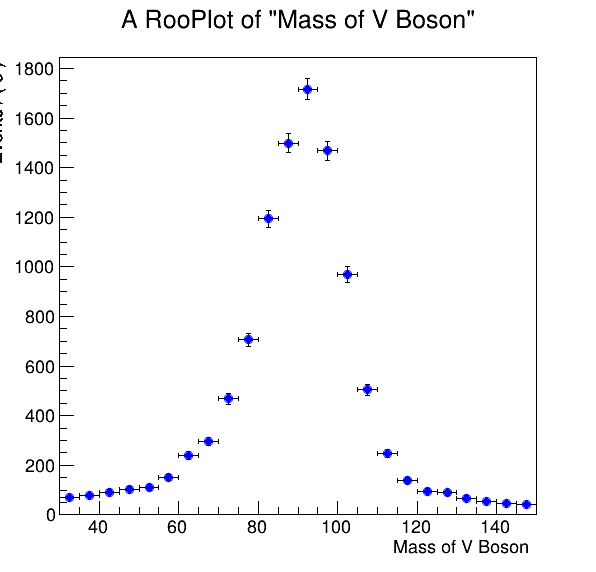

In [39]:
# import a tree
f = ROOT.TFile("./rootfiles/signal.root", "OPEN")
tree = f.Get("mumu")

# plot the events into a histo
histo = ROOT.TH1F("histo", "histo", 40, 0, 200)
tree.Draw("VCand_mass_tag>>histo")

# declare the variable
mass = ROOT.RooRealVar("mass", "Mass of V Boson", 30, 150)

# declare the DataHist with an imported Histogram
dh = ROOT.RooDataHist("dh", "dh", mass, ROOT.RooFit.Import(histo))

massFrame = mass.frame()

c.Clear()
dh.plotOn(massFrame, ROOT.RooFit.MarkerColor(ROOT.kBlue))
massFrame.Draw()
c.Draw()

Let's do one more fit, this time using a Bukin function on the DataHist above.

In [53]:
# pdf mean
m0 = ROOT.RooRealVar("m0", "CB mean", 85, 70, 100)

# pdf width
sig = ROOT.RooRealVar("sig", "CB width", 20, 0, 100)

# pdf asymmetry
xi = ROOT.RooRealVar("xi", "CB core asymmetry", 1, 0, 50)

# pdf tail
rho1 = ROOT.RooRealVar("rho1", "CB rho 1", 1, 0, 10)
rho2 = ROOT.RooRealVar("rho2", "CB rho 2", 1, 0, 10)

# CB pdf
bukin = ROOT.RooBukinPdf("cb", "Crystal Ball pdf", mass, m0, sig, xi, rho1, rho2)

# fitting
bukin.fitTo(dh)

<cppyy.gbl.RooFitResult object at 0x(nil)>

[#0] WARNING:InputArguments -- The parameter 'sig' with range [0, 100] of the RooBukinPdf 'cb' exceeds the safe range of (0, inf). Advise to limit its range.
[#0] WARNING:InputArguments -- The parameter 'rho1' with range [0, 10] of the RooBukinPdf 'cb' exceeds the safe range of (-1, 0). Advise to limit its range.
[#0] WARNING:InputArguments -- The parameter 'rho2' with range [0, 10] of the RooBukinPdf 'cb' exceeds the safe range of (0, 1). Advise to limit its range.
[#0] WARNING:InputArguments -- The parameter 'xi' with range [0, 50] of the RooBukinPdf 'cb' exceeds the safe range of (-1, 1). Advise to limit its range.
[#1] INFO:NumericIntegration -- RooRealIntegral::init(cb_Int[mass]) using numeric integrator RooIntegrator1D to calculate Int(mass)
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE    

[#1] INFO:NumericIntegration -- RooRealIntegral::init(cb_Int[mass]) using numeric integrator RooIntegrator1D to calculate Int(mass)


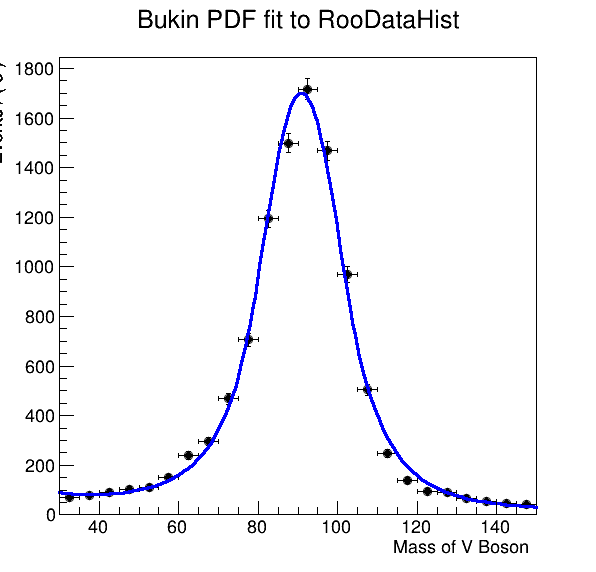

In [56]:
bukinFrame = mass.frame(ROOT.RooFit.Title("Bukin PDF fit to RooDataHist"))

dh.plotOn(bukinFrame)
bukin.plotOn(bukinFrame)

c.Clear()
bukinFrame.Draw()
c.Draw()

### RooDataSet: Unbinned Data

Generally, unbinned datasets can sometimes be more powerful. Prior examples have used the **RooDataSet** class, which is a sort of container for events without bins unlike RooDataHist. Each data point is considered, giving fits to the highest precision. Though, size can be a hindrance when it is too large as the process will take a much longer time.

Let's see the previously generated MC dataset:

In [57]:
data.Print("V")

DataStore gausData (Generated From gaussian PDF)
  Contains 1000 entries
  Observables: 
    1)  x = 3.38166  L(-10 - 10)  "x"


The RooDataSet contains 1000 events generated from a custom gaussian pdf on the variable x plane. We can import our own events from TTrees (and correspondingly, TChains).

In [63]:
# declare variables
vmass = ROOT.RooRealVar("VCand_mass_tag", "Mass of V boson", 85, 10, 200)
zmass = ROOT.RooRealVar("ZCand_mass", "Mass of Z Boson", 90, 10, 200)

# declare a container to hold some variables
arg = ROOT.RooArgSet(vmass, zmass)

ds = ROOT.RooDataSet("ds", "dataset", arg, ROOT.RooFit.Import(tree))
ds.Print("v")

[#1] INFO:DataHandling -- RooAbsReal::attachToTree(VCand_mass_tag) TTree Float_t branch VCand_mass_tag will be converted to double precision.
[#1] INFO:DataHandling -- RooAbsReal::attachToTree(ZCand_mass) TTree Float_t branch ZCand_mass will be converted to double precision.
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(ds) Skipping event #108 because VCand_mass_tag cannot accommodate the value 210.564
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(ds) Skipping event #272 because VCand_mass_tag cannot accommodate the value 200.158
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(ds) Skipping event #418 because VCand_mass_tag cannot accommodate the value 209.853
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(ds) Skipping event #545 because VCand_mass_tag cannot accommodate the value 208.278
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(ds) Skipping ...
[#0] WARNING:DataHandling -- RooTreeDataStore::loadValues(ds) Ignored 109 out-of-range events
Da

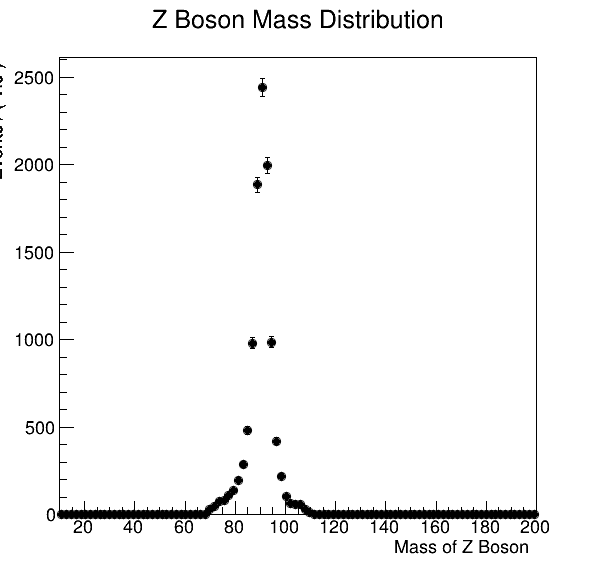

In [65]:
zframe = zmass.frame(ROOT.RooFit.Title("Z Boson Mass Distribution"))

ds.plotOn(zframe)

c.Clear()
zframe.Draw()
c.Draw()

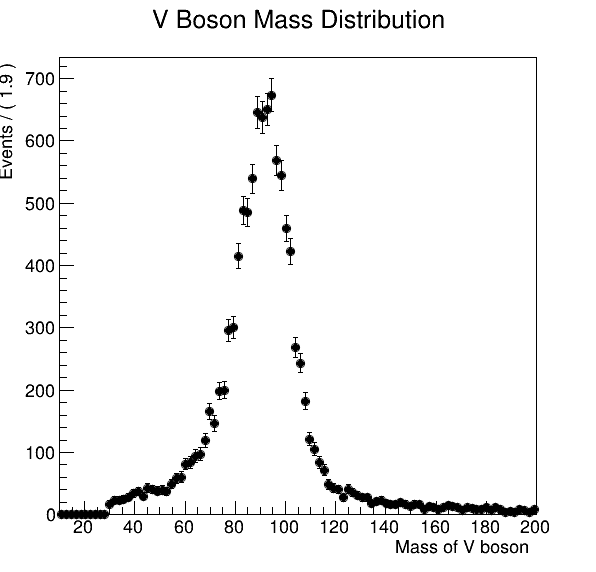

In [67]:
vframe = vmass.frame(ROOT.RooFit.Title("V Boson Mass Distribution"))

ds.plotOn(vframe)

c.Clear()
vframe.Draw()
c.Draw()

Check out the long list of built-in PDFs, among the more widely used ones:



|Background Shapes|RooFit Class|
|-----|-----|
|ARGUS| RooArgusBG|
|Breit-Wigner| RooBreitWigner|
|Bukin| RooBukinPdf|
|Crystal Ball| RooCBShape|
|Polynomials| RooPolynomial|
|Chebychev polynomials | RooChebychev|
|Exponential| RooExponential|
|Gaussian| RooGaussian|
|Landau| RooLandau|

It is also possible to construct a PDF of your own using the **RooGenericPdf** class:

```
func = "1-x+2*y"
genpdf = ROOT.RooGenericPdf(name, title, func, ROOT.RooArgList(x, y))
```


**Exercise: Use either a Crystal Ball function (RooCBShape) or a Bukin function (RooBukinPdf) or any other function you think is suitable, and fit it to the dataset on the V boson mass distribution.**

## RooAddPdf: Composite PDF Models

Real world samples are not as simple or clean as mathematical models tend to be, whereby they may include multiple processes or contributions. In particle physics, signal events and background events may have distribution shapes of their own, so a fit needs a PDF composite of both.

For this, we use the **RooAddPdf** class.

```
comp = ROOT.RooAddPdf(name, title, pdfList, coefList)
```

The PDF and coefficient lists need to use the **RooArgList** class to hold the member. The PDF added need not be a standalone PDF, but also RooAddPdf objects as well.

In [86]:
xvar = ROOT.RooRealVar("xvar", "x", 0, 100)

# background pdf model
const = ROOT.RooRealVar("const", "const", -0.5, -2, 2)
exp = ROOT.RooExponential("exp", "exp", x, const)

# first signal pdf model
mean1  = ROOT.RooRealVar("mean1", "mean1", 40, 20, 60)
sigma1 = ROOT.RooRealVar("sigma1", "sigma1", 5, 3, 7)
gaus1  = ROOT.RooGaussian("gaus1", "gaus1", xvar, mean1, sigma1)

# second signal pdf model
mean2  = ROOT.RooRealVar("mean2", "mean2", 45, 20, 60)
sigma2 = ROOT.RooRealVar("sigma2", "sigma2", 7, 3, 10)
gaus2  = ROOT.RooGaussian("gaus2", "gaus2", xvar, mean2, sigma2)

# composite signal pdf model
fsig1  = ROOT.RooRealVar("fsig1", "sig1 coefficient", 0.5, 0, 1.0)
fsig2  = ROOT.RooRealVar("fsig2", "sig2 coefficient", 0.5, 0, 1.0)
signal = ROOT.RooAddPdf("signal", "signal", ROOT.RooArgList(gaus1, gaus2), ROOT.RooArgList(fsig1, fsig2))

# background pdf model
const = ROOT.RooRealVar("const", "const", -0.05, -10, 2)
exp   = ROOT.RooExponential("exp", "exp", xvar, const)

# composite signal & background pdf model
fsig = ROOT.RooRealVar("fsig", "sig coefficient", 0.4, 0, 1.0)
fbkg = ROOT.RooRealVar("fbkg", "bkg coefficient", 0.6, 0, 1.0)
totalpdf = ROOT.RooAddPdf("totalpdf", "total pdf", ROOT.RooArgList(signal, exp), ROOT.RooArgList(fsig, fbkg))

We built 2 gaussian models and added them together as a single signal model, and later compiled the background to it as well.

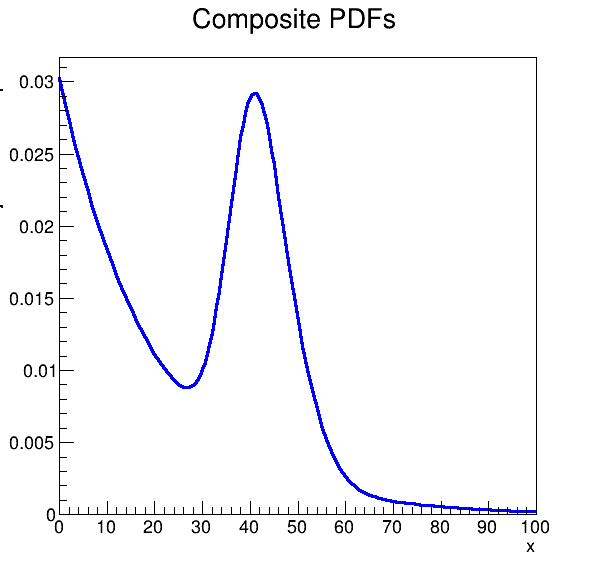

In [87]:
xframe = xvar.frame(ROOT.RooFit.Title("Composite PDFs"))

c.Clear()
totalpdf.plotOn(xframe)
xframe.Draw()
c.Draw()

### Plotting Composite Models

Even with composite models, it is useful to visualize the components of the composide PDF.

[#1] INFO:Plotting -- RooAbsPdf::plotOn(totalpdf) directly selected PDF components: (exp,gaus1)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(totalpdf) indirectly selected PDF components: (signal)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(totalpdf) directly selected PDF components: (exp)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(totalpdf) indirectly selected PDF components: ()


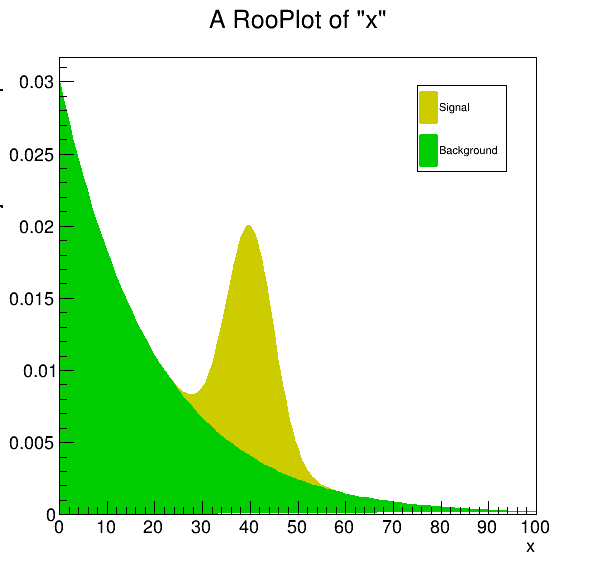

In [99]:
xframe = xvar.frame()

# plot the corresponding layers
totalpdf.plotOn(xframe, ROOT.RooFit.Components("exp,gaus1"), ROOT.RooFit.LineColor(ROOT.kYellow+1), \
                ROOT.RooFit.FillColor(ROOT.kYellow+1), ROOT.RooFit.FillStyle(1001), \
                ROOT.RooFit.DrawOption("F"), ROOT.RooFit.Name("Signal"))

# plot the background
totalpdf.plotOn(xframe, ROOT.RooFit.Components("exp"),       ROOT.RooFit.LineColor(ROOT.kGreen+1), \
                ROOT.RooFit.FillColor(ROOT.kGreen+1),    ROOT.RooFit.FillStyle(1001), \
                ROOT.RooFit.DrawOption("F"), ROOT.RooFit.Name("Background"))

# build legend

lgd = ROOT.TLegend(0.7, 0.7, 0.85, 0.85)
lgd.AddEntry("Signal", "Signal", "F")
lgd.AddEntry("Background", "Background", "F")


c.Clear()
xframe.Draw()
lgd.Draw()
c.Draw()


Though, if we want to distinguish the individual signal contributions, the RooAddPdf needs to be constructed a bit differently.

In [105]:
fsig1 = ROOT.RooRealVar("fsig1", "sig1 coefficient", 0.2, 0, 1.0)
fsig2 = ROOT.RooRealVar("fsig2", "sig2 coefficient", 0.2, 0, 1.0)
fbkg  = ROOT.RooRealVar("fbkg", "bkg coefficient", 0.6, 0, 1.0)

totalpdf2 = ROOT.RooAddPdf("totalpdf2", "totalpdf2", ROOT.RooArgList(gaus1, gaus2, exp), ROOT.RooArgList(fsig1, fsig2, fbkg))

[#1] INFO:Plotting -- RooAbsPdf::plotOn(totalpdf2) directly selected PDF components: (exp,gaus1)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(totalpdf2) indirectly selected PDF components: ()
[#1] INFO:Plotting -- RooAbsPdf::plotOn(totalpdf2) directly selected PDF components: (exp)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(totalpdf2) indirectly selected PDF components: ()


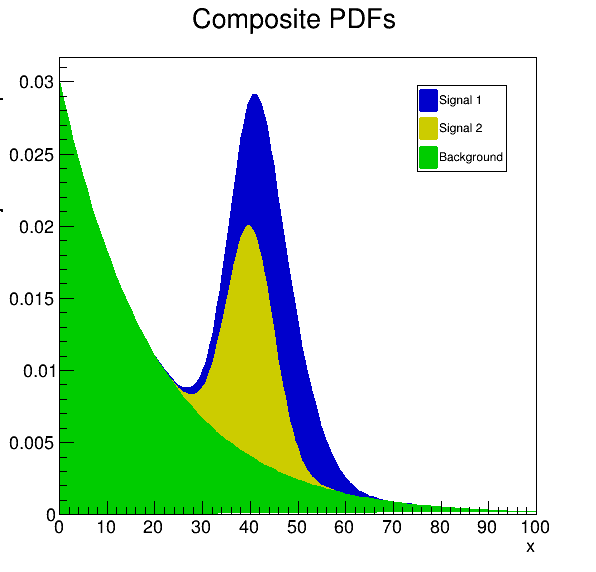

In [108]:
xframe = xvar.frame(ROOT.RooFit.Title("Composite PDFs"))

# plot the first signal layer
totalpdf2.plotOn(xframe, ROOT.RooFit.LineColor(ROOT.kBlue+1), \
                ROOT.RooFit.FillColor(ROOT.kBlue+1), ROOT.RooFit.FillStyle(1001), \
                ROOT.RooFit.DrawOption("F"), ROOT.RooFit.Name("gaus1"))

# plot the second signal layer
totalpdf2.plotOn(xframe, ROOT.RooFit.Components("exp,gaus1"), ROOT.RooFit.LineColor(ROOT.kYellow+1), \
                ROOT.RooFit.FillColor(ROOT.kYellow+1), ROOT.RooFit.FillStyle(1001), \
                ROOT.RooFit.DrawOption("F"), ROOT.RooFit.Name("gaus2"))

# plot the background
totalpdf2.plotOn(xframe, ROOT.RooFit.Components("exp"),       ROOT.RooFit.LineColor(ROOT.kGreen+1), \
                ROOT.RooFit.FillColor(ROOT.kGreen+1),    ROOT.RooFit.FillStyle(1001), \
                ROOT.RooFit.DrawOption("F"), ROOT.RooFit.Name("bkg"))

# build legend
lgd = ROOT.TLegend(0.7, 0.7, 0.85, 0.85)
lgd.AddEntry("gaus1", "Signal 1", "F")
lgd.AddEntry("gaus2", "Signal 2", "F")
lgd.AddEntry("bkg", "Background", "F")


c.Clear()
xframe.Draw()
lgd.Draw()
c.Draw()